## Summarising data across repeated runs of same workload 

In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITHOUT_ISTIO_WITHOUT_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

#### Identifying most important functions by count

In [3]:

def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [4]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

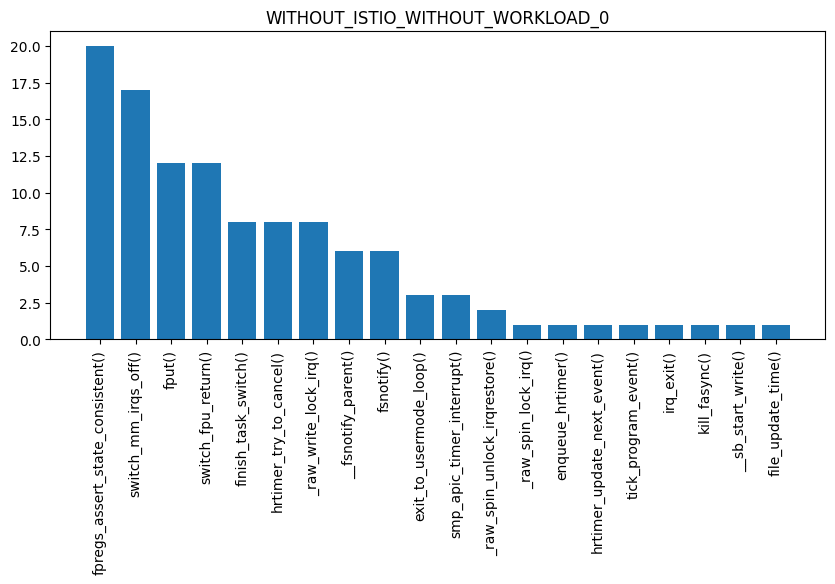

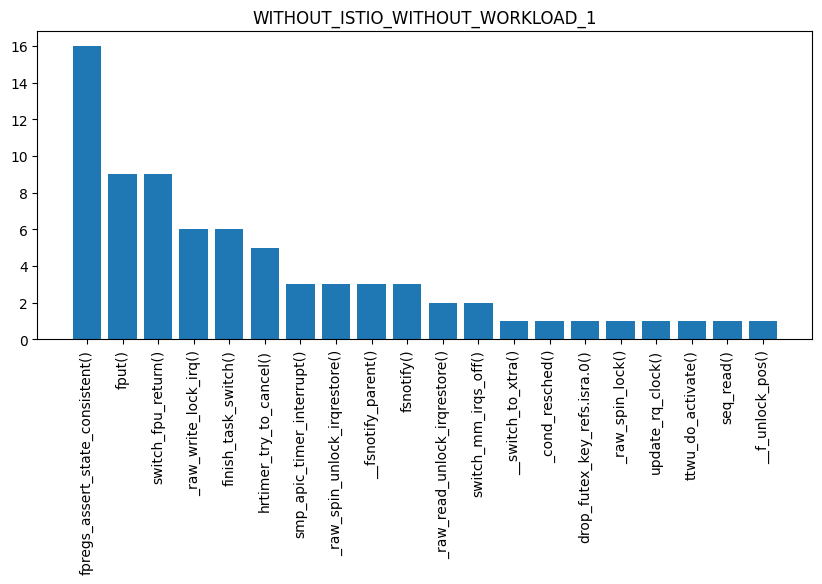

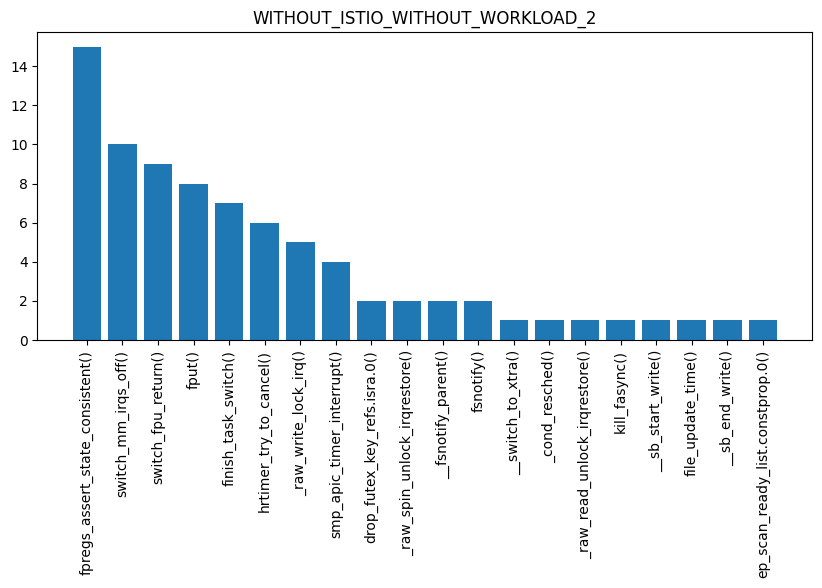

In [5]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i])
    plot_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

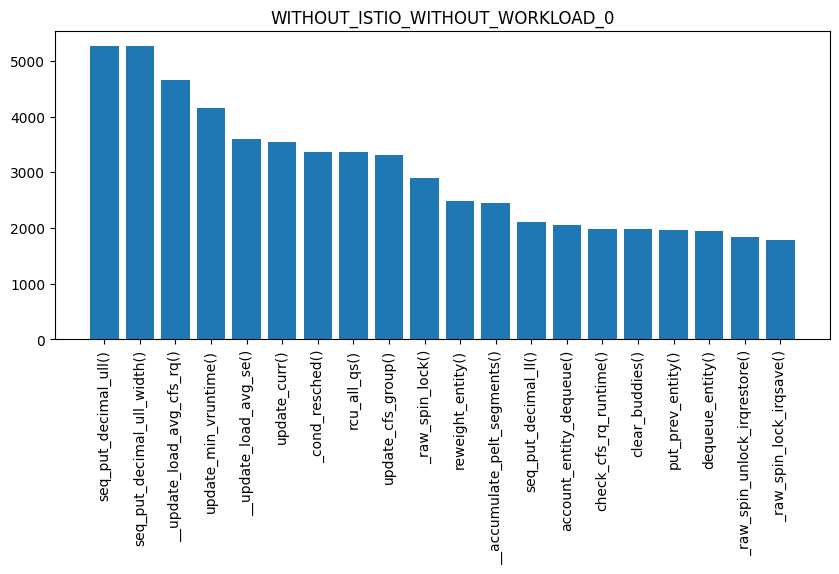

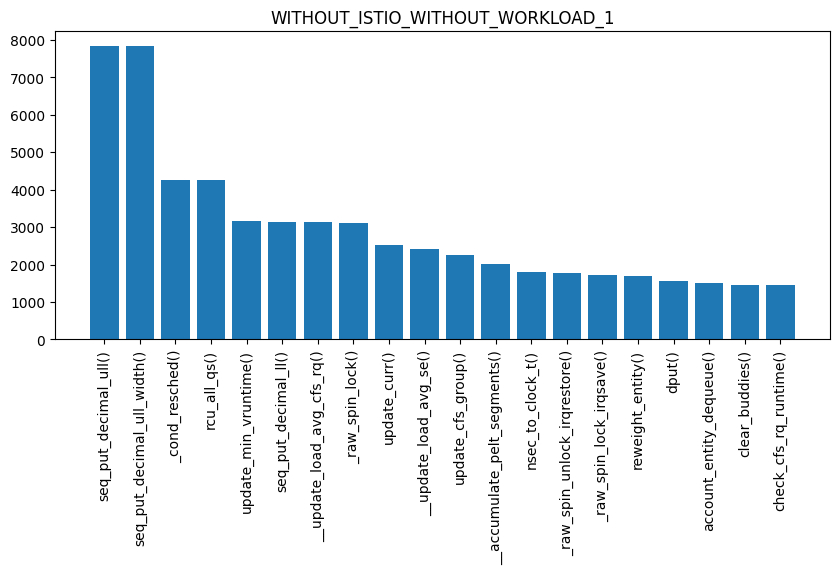

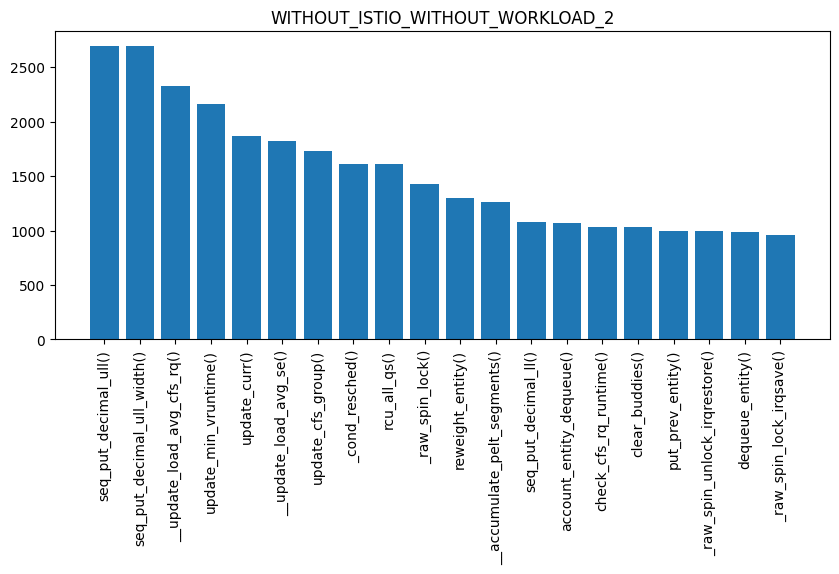

In [6]:
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i], recurse=True)
    plot_counts(count, title=f"{WORKLOAD}_{i}")

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

762 455 662


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'skb_try_coalesce()', 'nf_conntrack_in [nf_conntrack]()', 'nf_nat_ipv4_out [nf_nat]()', 'security_sock_rcv_skb()', 'sk_page_frag_refill()', '__local_bh_enable_ip()', 'iptable_raw_hook [iptable_raw]()', 'nf_confirm [nf_conntrack]()', 'bbr_update_model [tcp_bbr]()', 'ip_vs_in.part.0 [ip_vs]()', 'tcp_poll()', 'unix_stream_recvmsg()', 'tcp_rbtree_insert()', 'skb_csum_hwoffload_help()', 'tcp_recvmsg()', 'do_writev()', 'iptable_mangle_hook [iptable_mangle]()', '__memcg_kmem_uncharge_memcg()', 'comment_mt [xt_comment]()', 'destroy_context_ldt()', 'tcp_sendmsg()', '__copy_skb_header()', 'calc_wheel_index()', 'nf_nat_ipv4_fn [nf_nat]()', 'tcp_rack_advance()', 'do_readv()', 'anon_pipe_buf_release()', 'call_timer_fn()', 'fpu__clear()', 'do_iter_write()', '__kmalloc_reserve.isra.0()', 'ip_local_out()', '__skb_clone()', 'unix_write_space()', 'eth_type_trans()', 'tcp_options_write()', 'tcp_event_data_recv()', 'sock_rfree()', '__free_pages_ok()', 'tcp_v4_inbound_md5_hash()',

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('hrtimer_reprogram()', 100.0),
 ('pipe_poll()', 100.0),
 ('new_sync_read()', 100.0),
 ('pipe_read()', 100.0),
 ('generic_pipe_buf_confirm()', 100.0),
 ('anon_pipe_buf_release()', 100.0),
 ('touch_atime()', 100.0),
 ('atime_needs_update()', 100.0),
 ('__mnt_drop_write()', 100.0),
 ('call_timer_fn()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('sock_poll()', 100.0),
 ('tcp_poll()', 100.0),
 ('__x64_sys_nanosleep()', 100.0),
 ('get_timespec64()', 100.0),
 ('hrtimer_nanosleep()', 100.0),
 ('do_nanosleep()', 100.0),
 ('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('__free_pages_ok()', 100.0),
 ('__memcg_kmem_uncharge()', 100.0),
 ('__memcg_kmem_uncharge_memcg()', 100.0),
 ('page_counter_uncharge()', 100.0),
 ('page_counter_cancel()', 100.0),
 ('propagate_protected_usage()', 100.0),
 ('kernel_poison_pages()', 100.0),

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('tcp_poll()', 100.0),
 ('__x64_sys_nanosleep()', 100.0),
 ('get_timespec64()', 100.0),
 ('hrtimer_nanosleep()', 100.0),
 ('do_nanosleep()', 100.0),
 ('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('__free_pages_ok()', 100.0),
 ('__memcg_kmem_uncharge()', 100.0),
 ('__memcg_kmem_uncharge_memcg()', 100.0),
 ('page_counter_uncharge()', 100.0),
 ('page_counter_cancel()', 100.0),
 ('propagate_protected_usage()', 100.0),
 ('kernel_poison_pages()', 100.0),
 ('free_one_page()', 100.0),
 ('__mod_zone_page_state()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('smp_call_function_interrupt()', 100.0),
 ('generic_smp_call_function_single_interrupt()', 100.0),
 ('flush_smp_call_function_queue()', 100.0),
 ('flush_tlb_func_remo

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('__d_free_external()', 100.0),
 ('__d_free()', 100.0),
 ('delayed_put_pid()', 100.0),
 ('put_pid.part.0()', 100.0),
 ('put_pid_ns()', 100.0),
 ('delayed_put_task_struct()', 100.0),
 ('__put_task_struct()', 100.0),
 ('cgroup_free()', 100.0),
 ('task_numa_free()', 100.0),
 ('security_task_free()', 100.0),
 ('yama_task_free()', 100.0),
 ('yama_ptracer_del()', 100.0),
 ('apparmor_task_free()', 100.0),
 ('exit_creds()', 100.0),
 ('key_put()', 100.0),
 ('profile_handoff_task()', 100.0),
 ('atomic_notifier_call_chain()', 100.0),
 ('free_task()', 100.0),
 ('put_seccomp_filter()', 100.0),
 ('__put_seccomp_filter()', 100.0),
 ('arch_release_task_struct()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('start_cfs_bandwidth.part.0()', 83.33333333333334),
 ('check_spread.isra.0.part.0()', 80.0),
 ('eventfd_poll()', 50.0),
 ('eventfd_read()', 50.0),
 ('rcu_cblist_dequeue()', 4

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('tcp_keepalive_timer()', 100.0),
 ('tcp_write_wakeup()', 100.0),
 ('tcp_xmit_probe_skb()', 100.0),
 ('inet_csk_reset_keepalive_timer()', 100.0),
 ('tcp_validate_incoming()', 100.0),
 ('tcp_oow_rate_limited()', 100.0),
 ('tcp_send_dupack()', 100.0),
 ('tcp_drop()', 100.0),
 ('process_timeout()', 100.0),
 ('start_cfs_bandwidth.part.0()', 80.0),
 ('check_preempt_wakeup()', 37.5),
 ('__next_timer_interrupt()', 25.0),
 ('pick_next_entity()', 12.195121951219512),
 ('__rseq_handle_notify_resume()', 7.5),
 ('clear_user()', 6.25),
 ('__clear_user()', 5.0),
 ('__account_cfs_rq_runtime()', 4.787234042553192),
 ('eventfd_write()', 4.166666666666666),
 ('__wake_up_locked_key()', 4.123711340206185)]

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('pipe_poll()', 100.0),
 ('hrtimer_reprogram()', 100.0),
 ('new_sync_read()', 100.0),
 ('pipe_read()', 100.0),
 ('generic_pipe_buf_confirm()', 100.0),
 ('anon_pipe_buf_release()', 100.0),
 ('touch_atime()', 100.0),
 ('atime_needs_update()', 100.0),
 ('__mnt_drop_write()', 100.0),
 ('sock_write_iter()', 100.0),
 ('sock_sendmsg()', 100.0),
 ('security_socket_sendmsg()', 100.0),
 ('apparmor_socket_sendmsg()', 100.0),
 ('aa_sk_perm()', 100.0),
 ('aa_label_sk_perm.part.0()', 100.0),
 ('aa_profile_af_perm()', 100.0),
 ('aa_apply_modes_to_perms()', 100.0),
 ('aa_check_perms()', 100.0),
 ('inet_sendmsg()', 100.0),
 ('inet_send_prepare()', 100.0),
 ('tcp_sendmsg()', 100.0),
 ('lock_sock_nested()', 100.0),
 ('_raw_spin_lock_bh()', 100.0),
 ('__local_bh_enable_ip()', 100.0),
 ('tcp_sendmsg_locked()', 100.0),
 ('tcp_rate_check_app_limited()', 100.0),
 ('tcp_send_mss()', 100.0),
 ('tcp_current_mss()', 100.0),
 ('ipv4_mtu()', 100.0),
 ('tcp_established_options()', 100.0),
 ('sk_stream_alloc_skb()',

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('tick_do_update_jiffies64.part.0()', 100.0),
 ('do_timer()', 100.0),
 ('calc_global_load()', 100.0),
 ('update_wall_time()', 100.0),
 ('timekeeping_advance()', 100.0),
 ('ntp_tick_length()', 100.0),
 ('timekeeping_update()', 100.0),
 ('ntp_get_next_leap()', 100.0),
 ('update_vsyscall()', 100.0),
 ('raw_notifier_call_chain()', 100.0),
 ('notifier_call_chain()', 100.0),
 ('update_fast_timekeeper()', 100.0),
 ('check_spread.isra.0.part.0()', 100.0),
 ('rcu_do_batch()', 100.0),
 ('rcu_segcblist_extract_done_cbs()', 100.0),
 ('rcu_cblist_dequeue()', 100.0),
 ('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('file_free_rcu()', 100.0),
 ('__d_free_external()', 100.0),
 ('__d_free()', 100.0),
 ('delayed_put_pid()', 100.0),
 ('put_pid.part.0()', 100.0),
 ('put_pid_ns()', 100.0),
 ('delayed_put_task_struct()', 100.0),
 ('__put_task_struct()', 100.0),
 ('cgroup_free()', 100.0),
 ('task_numa_free()', 100.0),
 ('security_ta

## Plotting Distribution of the runs 
Aim: To figure out which frequency most of the functions lie, select functions over a threshold frequency and use them as a baseline to eliminate noise from other runs

In [18]:
def plot_hist(count, title, maxrange=2000):
    x = count.values()

    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.hist(x, histtype="bar", bins=50, range=(0,maxrange))
    plt.show()
    del x

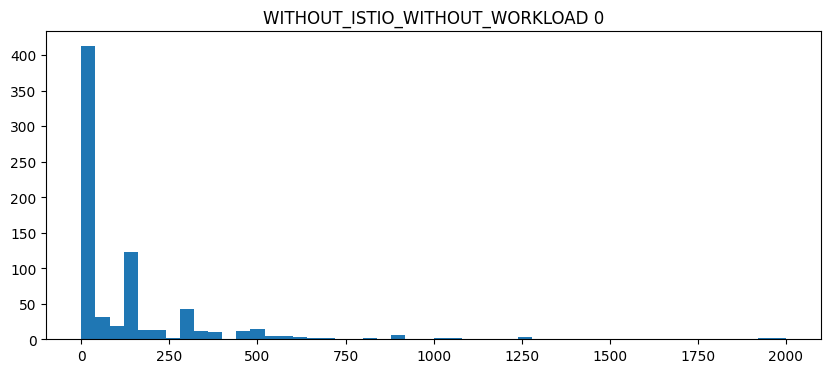

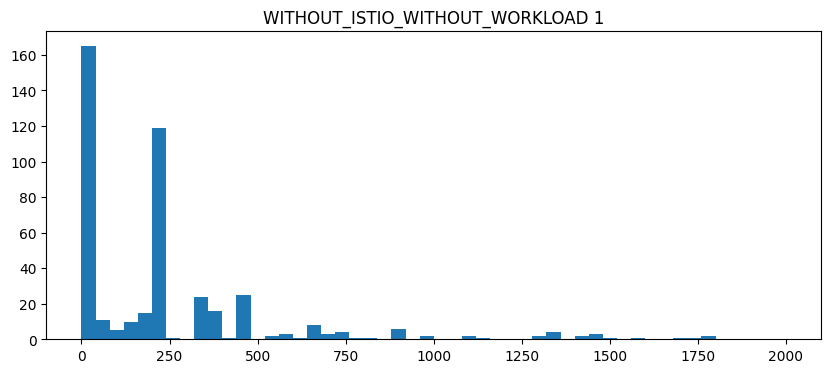

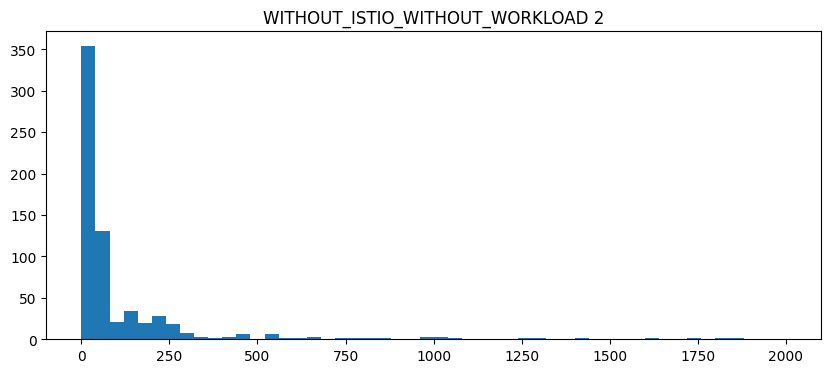

In [19]:
i=0
for count in function_counts:
    plot_hist(count, f"{WORKLOAD} {i}")
    i += 1
del i

We observe that a clear majority of function calls are within at most 250~300 counts. Thus we will use 300 as a threshold to filter out the important function calls i.e, freq higher than 300

In [20]:
def get_baseline(count, max_freq=250):
    return list(filter(lambda x: count[x]>max_freq, count.keys()))

In [21]:
baseline = {}
for count in function_counts:
    for func in get_baseline(count):
        baseline[func] = {
            "count": count[func] + baseline.get(func, {"count":0})["count"],
            "num": 1 + baseline.get(func, {"num":0})["num"]
        }
    
# Calculate arithmetic mean of the various baselines to obtain 1 consolidated run 
for func in baseline:
    baseline[func] = baseline[func]["count"] // baseline[func]["num"]

In [22]:
len(baseline), baseline

(152,
 {'syscall_trace_enter()': 542,
  '__secure_computing()': 542,
  '__seccomp_filter()': 542,
  '__fdget_pos()': 382,
  '__fget_light()': 651,
  'rw_verify_area()': 382,
  'security_file_permission()': 382,
  'apparmor_file_permission()': 382,
  'common_file_perm()': 382,
  'aa_file_perm()': 382,
  'mutex_lock()': 453,
  '_cond_resched()': 3080,
  'rcu_all_qs()': 3080,
  'mutex_unlock()': 456,
  '__wake_up_common_lock()': 353,
  '_raw_spin_lock_irqsave()': 1490,
  '__wake_up_common()': 342,
  'try_to_wake_up()': 331,
  'select_task_rq_fair()': 328,
  'available_idle_cpu()': 710,
  'update_cfs_rq_h_load()': 283,
  'select_idle_sibling()': 328,
  '_raw_spin_lock()': 2482,
  'update_rq_clock()': 799,
  'ttwu_do_activate()': 329,
  'activate_task()': 329,
  'psi_task_change()': 595,
  'record_times()': 1190,
  'enqueue_task_fair()': 324,
  'enqueue_entity()': 878,
  'update_curr()': 2641,
  '__update_load_avg_se()': 2615,
  '__update_load_avg_cfs_rq()': 3376,
  'update_cfs_group()': 24

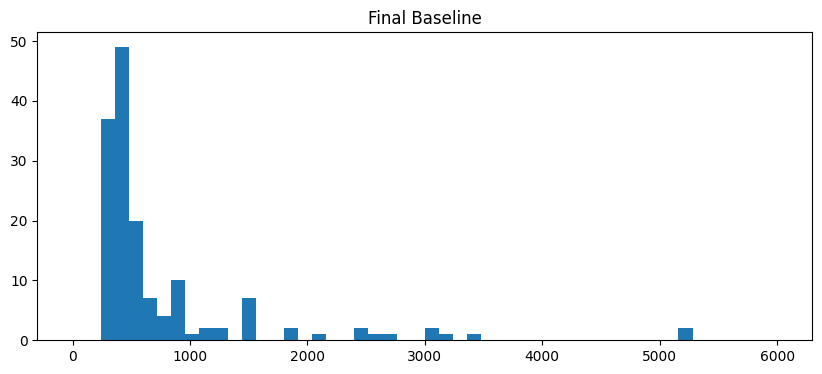

In [23]:
plot_hist(baseline, "Final Baseline", maxrange=6000)

In [24]:
with open(f"pickles/baselines/{WORKLOAD}", "wb+") as f:
    pickle.dump(baseline, f)

In [5]:
def get_latency(run, blacklist=FUNC_BLACKLIST):
    latency = {}
    print(blacklist)
    
    def update_latency(data):
        
        for call in data:
            function_name = call['function_name']
            if function_name not in blacklist:              
                latency[function_name] = latency.get(function_name, 0) + call['time']
                
                for child in call['children']:
                    latency[function_name] -= child['time']

            update_latency(call['children'])
    
    for data in run.values():
        update_latency(data)

    return latency

In [6]:
runs = get_runs()

{'do_syscall_64()', 'BLANK'}
{'do_syscall_64()', 'BLANK'}
{'do_syscall_64()', 'BLANK'}


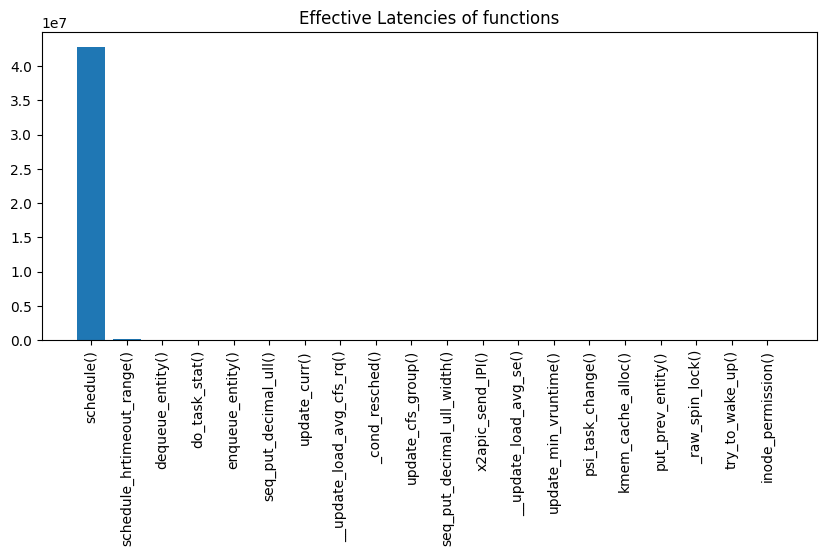

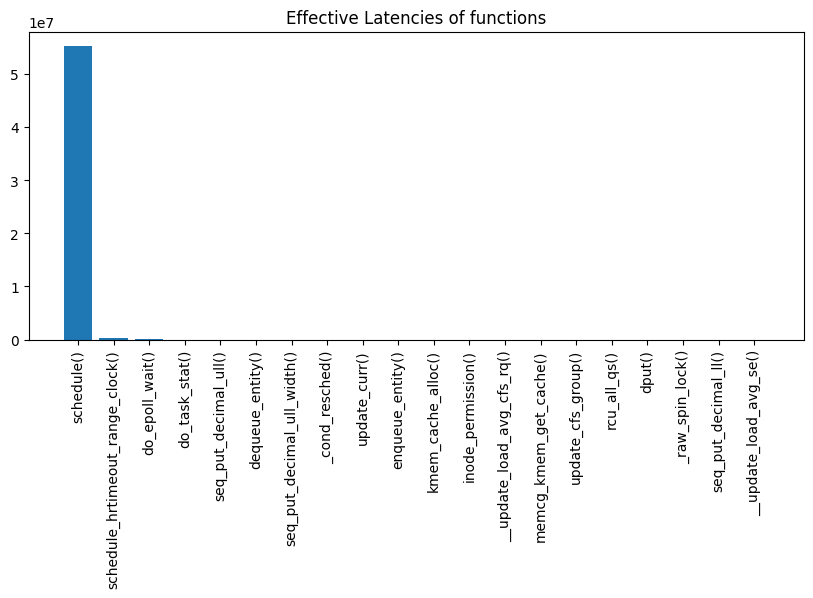

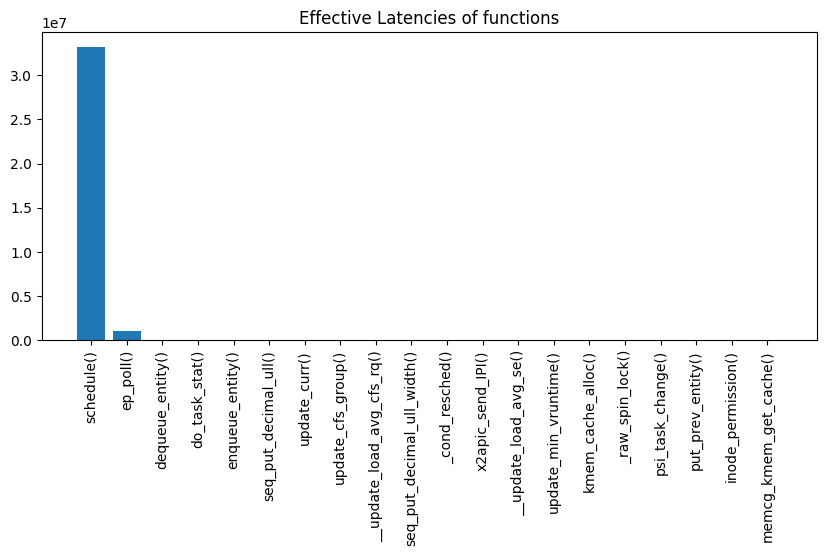

In [7]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_latency(runs[i]))

for latency in latencies:
    plot_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

**The schedule() functions:**<br/>
It is a kernel function which is responsible for running the linux scheduler. It is called whenever there is an interrupt and it handles the process of switching threads. waking up threads, etc

It is the most time consuming function in the 01 workload and takes 2-2.5s of time overall which is 60s

{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}


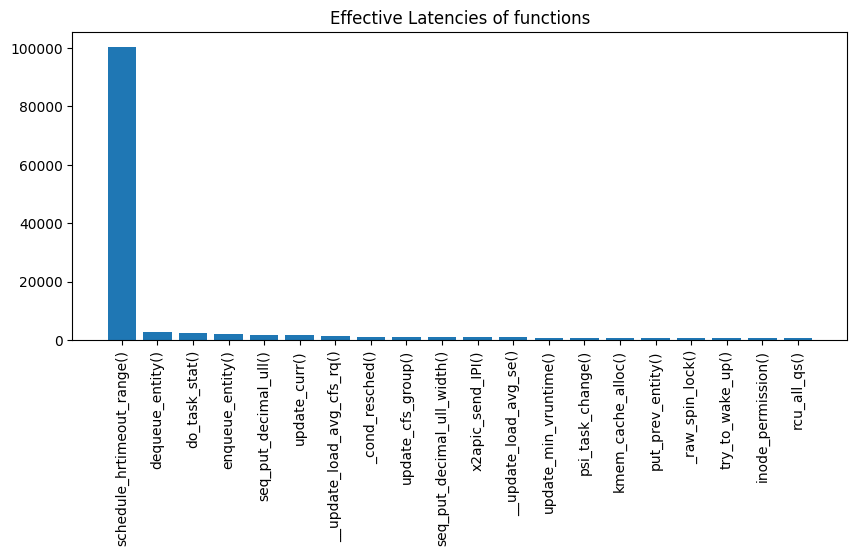

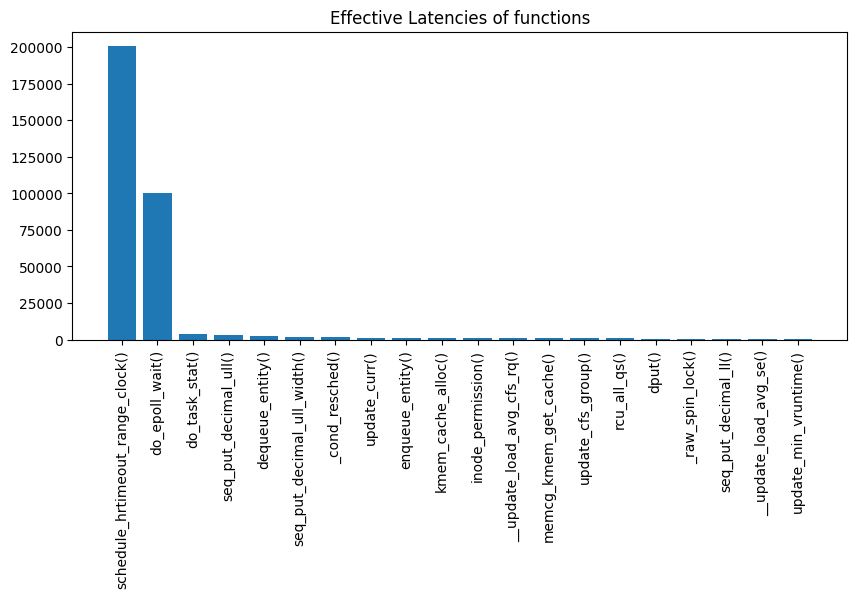

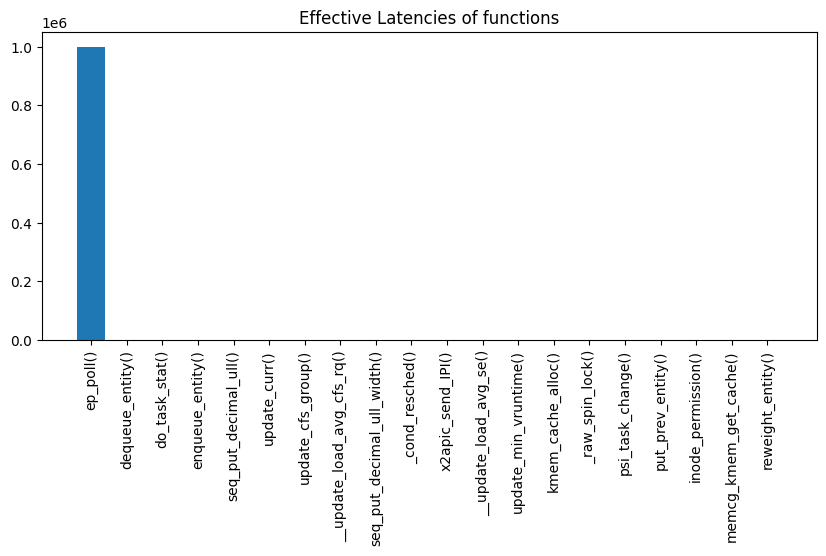

In [8]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_latency(runs[i], FUNC_BLACKLIST.union({"schedule()"})))

for latency in latencies:
    plot_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

In [15]:
latencies[0]['schedule_hrtimeout_range()']

100387.50000000016